In [1]:
import pandas as pd
import numpy as np

import mne
from mne.time_frequency import psd_welch

import helper as helper #custom

# visualization stuff
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# 1. Import Data

In [2]:
df = pd.read_csv('data/anger-amuse-100trials-3s.csv')

In [3]:
df.shape #check the size of 0

(105840, 10)

In [4]:
print(df[df.Marker==2].shape) #anger
print(df[df.Marker==1].shape) #amusements

(53, 10)
(47, 10)


df.rename(columns={'Unnamed: 1':'Fp1',
                          'Unnamed: 2':'Fp2',
                          'Unnamed: 3':'F3',
                          'Unnamed: 4':'F4'}, 
                 inplace=True)

In [5]:
df.rename(columns={'Unnamed: 1':'Fp1',
                          'Unnamed: 2':'Fpz',
                          'Unnamed: 3':'Fp2',
                          'Unnamed: 4':'AF3',
                          'Unnamed: 5':'AFz',
                          'Unnamed: 6':'AF4',
                          'Unnamed: 7':'F3',
                          'Unnamed: 8':'F4'}, 
                 inplace=True)

In [6]:
df.head()

,timestamps,Fp1,Fpz,Fp2,AF3,AFz,AF4,F3,F4,Marker
0,284.459,46120.320,65705.141,64420.434,54059.660,31135.398,68824.617,37359.129,47143.004,0
1,284.460,46205.281,65767.414,64490.930,54136.953,31214.547,68840.961,37443.887,47219.938,0
2,284.461,46206.062,65770.430,64493.121,54139.859,31206.723,68854.750,37433.875,47207.711,0
3,284.461,46142.852,65727.000,64453.422,54082.973,31142.037,68867.492,37362.797,47139.246,0
4,284.462,46092.852,65683.414,64418.242,54038.562,31099.256,68859.805,37319.434,47102.883,0


df = df.drop(["timestamps", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8"], axis=1)

In [7]:
df = df.drop(["timestamps"], axis=1)

In [8]:
df.shape

(105840, 9)

# 2. Transform Data into Raw MNE object

Creating RawArray with float64 data, n_channels=9, n_times=105840
    Range : 0 ... 105839 =      0.000 ...   423.356 secs
Ready.
Effective window size : 8.192 (s)


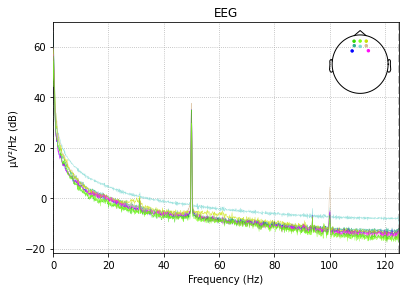

In [9]:
raw = helper.df_to_raw(df)

# 3. Preprocessing

## Notch Filter

Some artifacts are restricted to certain frequencies and can therefore be fixed by filtering. An artifact that typically affects only some frequencies is due to the power line.

Power-line noise is a noise created by the electrical network. It is composed of sharp peaks at 50Hz (or 60Hz depending on your geographical location). Some peaks may also be present at the harmonic frequencies, i.e. the integer multiples of the power-line frequency, e.g. 100Hz, 150Hz, … (or 120Hz, 180Hz, …).

Remove the 50Hz power line noise in Thailand.  We will also be remove its harmonics, i.e., 100Hz, 150Hz, etc.  Since our signal is 125Hz (250Hz / 2 according to Nyquist Theorem), we shall run the harmonics until 125 Hz.

In [10]:
raw.notch_filter(np.arange(50, 125, 50), filter_length='auto', phase='zero') #250/2 based on Nyquist Theorem

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)



<RawArray | 9 x 105840 (423.4 s), ~7.3 MB, data loaded>

Effective window size : 8.192 (s)


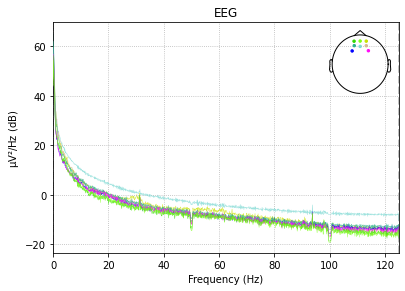

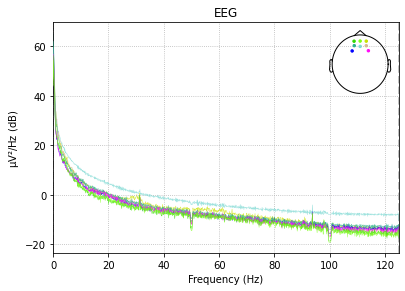

In [11]:
#observe that the 50Hz noise is now gone, yay!
raw.plot_psd()

## Band pass filter

If we are working on ERP (e.g., P300, SSVEP, N170), then we need to filter out all frequences between 1 and 30hz in order to increase our ability to detect them.

Since we are interested in spectral analysis, our interested band is around 4 and 50Hz

In [12]:
#Filter code looks like this
raw.filter(4,50, method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 50.00 Hz: -6.02, -6.02 dB



<RawArray | 9 x 105840 (423.4 s), ~7.3 MB, data loaded>

## Independent component analysis

Independent components analysis (ICA) is a technique for estimating independent source signals from a set of recordings in which the source signals were mixed together in unknown ratios. A common example of this is the problem of blind source separation: with 3 musical instruments playing in the same room, and 3 microphones recording the performance (each picking up all 3 instruments, but at varying levels), can you somehow “unmix” the signals recorded by the 3 microphones so that you end up with a separate “recording” isolating the sound of each instrument?

It is not hard to see how this analogy applies to EEG/MEG analysis: there are many “microphones” (sensor channels) simultaneously recording many “instruments” (blinks, heartbeats, activity in different areas of the brain, muscular activity from jaw clenching or swallowing, etc). As long as these various source signals are statistically independent and non-gaussian, it is usually possible to separate the sources using ICA, and then re-construct the sensor signals after excluding the sources that are unwanted.

MNE-Python implements three different ICA algorithms: fastica (the default), picard, and infomax. FastICA and Infomax are both in fairly widespread use; Picard is a newer (2017) algorithm that is expected to converge faster than FastICA and Infomax, and is more robust than other algorithms in cases where the sources are not completely independent, which typically happens with real EEG/MEG data

The ICA interface in MNE-Python is similar to the interface in scikit-learn: some general parameters are specified when creating an ICA object, then the ICA object is fit to the data using its fit() method. The results of the fitting are added to the ICA object as attributes that end in an underscore (_), such as ica.mixing_matrix_ and ica.unmixing_matrix_. After fitting, the ICA component(s) that you want to remove must be chosen, and the ICA fit must then be applied to the Raw or Epochs object using the ICA object’s apply() method.

After visualizing the Independent Components (ICs) and excluding any that capture artifacts you want to repair, the sensor signal can be reconstructed using the ICA object’s apply() method. By default, signal reconstruction uses all of the ICs (less any ICs listed in ICA.exclude) plus all of the PCs that were not included in the ICA decomposition (i.e., the “PCA residual”). If you want to reduce the number of components used at the reconstruction stage, it is controlled by the n_pca_components parameter (which will in turn reduce the rank of your data; by default n_pca_components = max_pca_components resulting in no additional dimensionality reduction). 

Before we run the ICA, an important step is filtering the data to remove low-frequency drifts, which can negatively affect the quality of the ICA fit. The slow drifts are problematic because they reduce the independence of the assumed-to-be-independent sources (e.g., during a slow upward drift, the neural, heartbeat, blink, and other muscular sources will all tend to have higher values), making it harder for the algorithm to find an accurate solution. **A high-pass filter with 1 Hz cutoff frequency is recommended before performing ICA.  However when we transform ICA (signal reconstruction), we reconstruct based on the original signal that did not perform 1Hz cutoff.** However, because filtering is a linear operation, the ICA solution found from the filtered signal can be applied to the unfiltered signal, so we’ll keep a copy of the unfiltered Raw object around so we can apply the ICA solution to it later.

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)

Effective window size : 8.192 (s)


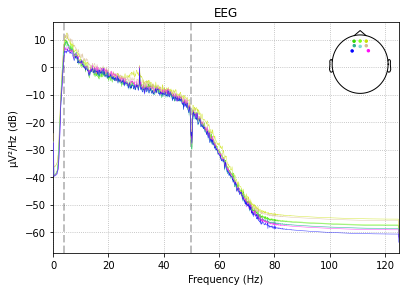

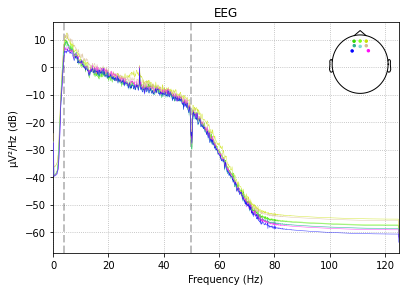

In [13]:
#filtering to remove slow drifts; also make copy of raw for later signal reconstruction
from mne.preprocessing import ICA

filt_raw = raw.copy()
filt_raw.load_data().filter(l_freq=1., h_freq=None)
filt_raw.plot_psd()

Now we’re ready to set up and fit the ICA. **We’ll run ICA with n_components=8 since we only have 8 channels.**  If we have more, then we may pick a smaller number.  How small?  There is no answer, but clearly, we want to try until we can see the eye, muscle components, etc.  But too large the component will slow the fit() process.

ICA fitting is not deterministic (e.g., the components may get a sign flip on different runs, or may not always be returned in the same order), so we’ll also specify a random seed so that we get identical results each time this tutorial is built by our web servers.

In [14]:
# set up and fit the ICA
ica = ICA(n_components=8, random_state=32)
ica.fit(filt_raw)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 8 components
Fitting ICA took 2.1s.


<ICA  |  raw data decomposition, fit (fastica): 105840 samples, 8 components, channels used: "eeg">

Now we can examine the ICs to see what they captured. plot_sources() will show the time series of the ICs. Note that in our call to plot_sources() we can use the original, unfiltered Raw object:

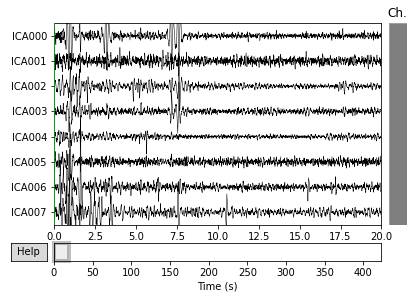

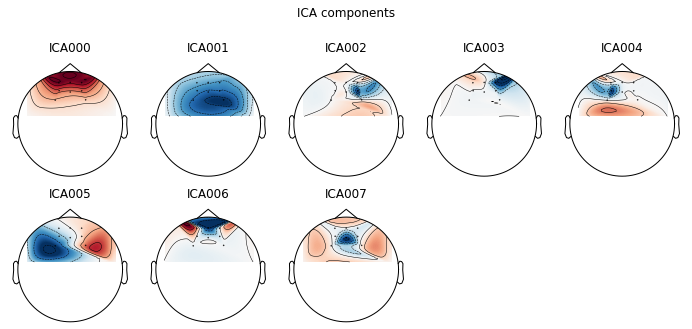

[<Figure size 702x339.12 with 8 Axes>]

In [15]:
ica.plot_sources(filt_raw)
ica.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows
211 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
211 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
211 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
211 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
211 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
211 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
211 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
211 matching events found
No baseline corre

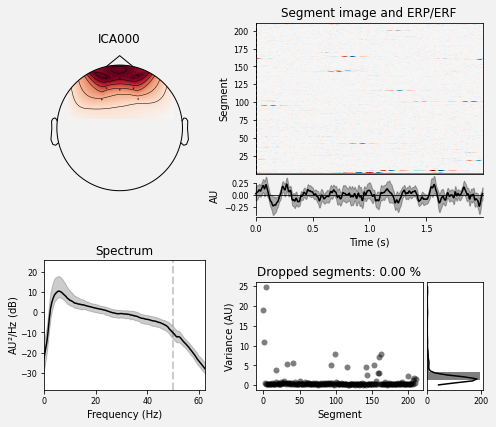

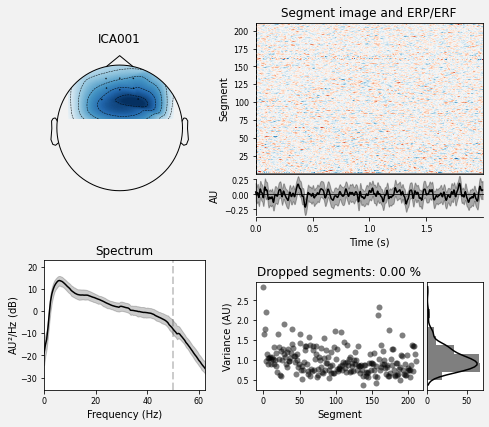

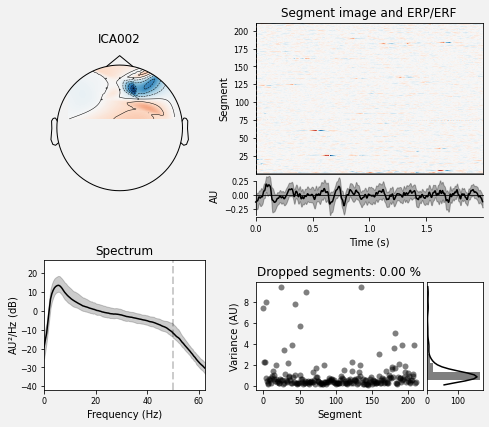

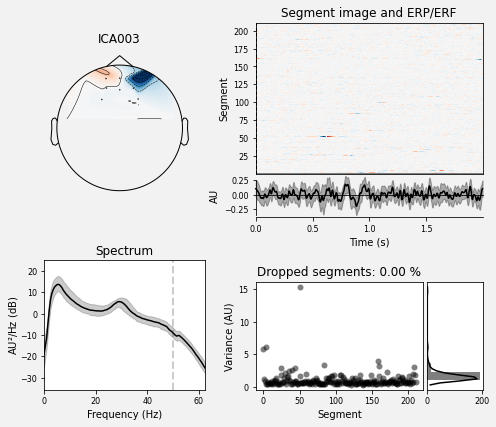

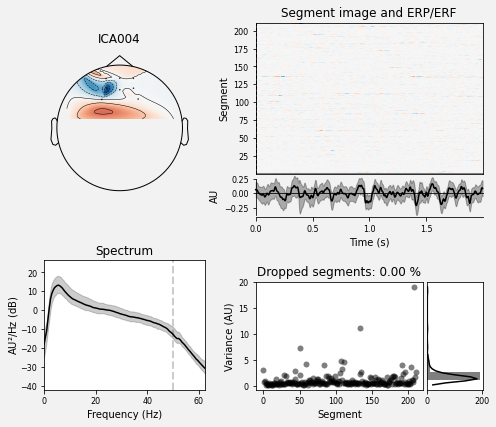

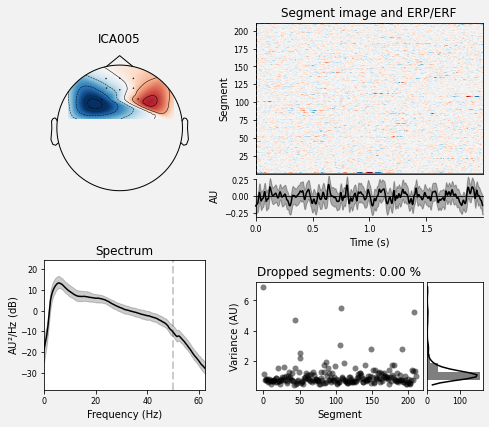

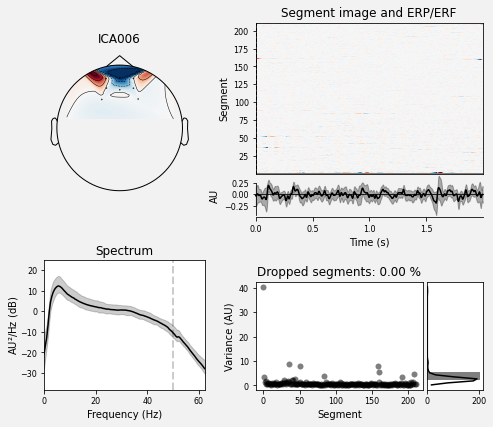

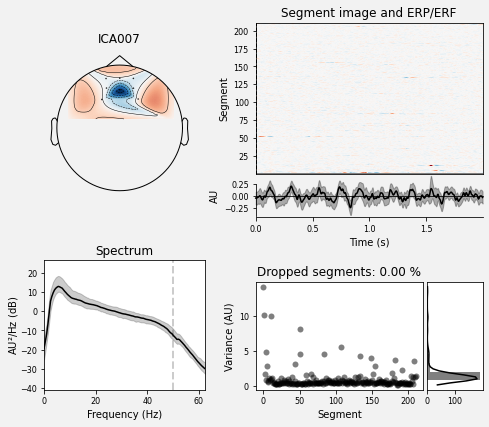

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [16]:
ica.plot_properties(filt_raw, picks=[0,1,2,3, 4, 5, 6, 7])

The verdict is not so clear.  But usually the artifact is around first couple components since they explained most of the variances happenining on the data.  Here, component 0, 2, 3 all looks suspecting (for more info on visually identifying Independent Components, this EEGLAB tutorial (https://labeling.ucsd.edu/tutorial/labels) is a good resource). 

Typically, while brain activity exists at frequencies that surpass 200 Hz, low frequencies are typically the only ones synchronous enough to show up in EEG. Therefore, **brain components** tend to have diminishing power at higher frequencies.  In other words, most higher frequencies data are usually artifacts.   Additionally, for all **eye components**, the power spectrum will vary due to experiments and people, but generally most of the power will reside at frequencies below 5 Hz as people do not usually move their eye faster than that. **Muscle components** are mostly concentrated in higher frequences (20Hz and above).  These components can still be dipolar, but will be located outside the skull, i.e., shallow source as seen in topography.

We can also visualize the scalp field distribution of each component using plot_components(). These are interpolated based on the values in the ICA unmixing matrix:

We can alo plot an overlay of the original signal against the reconstructed signal with the artifactual ICs excluded, using plot_overlay():

Transforming to ICA space (8 components)
Zeroing out 1 ICA component


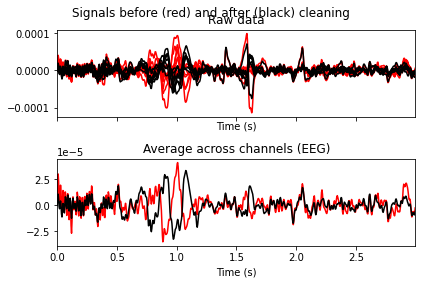

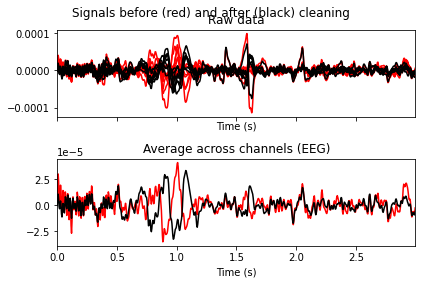

In [17]:
#test excluding 0 component
ica.plot_overlay(filt_raw, exclude=[0], picks='eeg')

We can also plot some diagnostics of each IC using plot_properties():

Once we’re certain which components we want to exclude, we can specify that manually by setting the **ica.exclude** attribute. Similar to marking bad channels, merely setting ica.exclude doesn’t do anything immediately (it just adds the excluded ICs to a list that will get used later when it’s needed). Once the exclusions have been set, ICA methods like plot_overlay() will exclude those component(s) even if no exclude parameter is passed, and the list of excluded components will be preserved when using mne.preprocessing.ICA.save() and mne.preprocessing.read_ica().

In [18]:
ica.exclude = [0] #we want to cut down the 0, 1 component, then apply(self) to reconstruct the signal

Once we’re confident about which component(s) we want to remove, we pass them as the exclude parameter and then apply the ICA to the raw signal. The apply() method requires the raw data to be loaded into memory (by default it’s only read from disk as-needed), so we’ll use load_data() first. We’ll also make a copy of the Raw object so we can compare the signal before and after artifact removal side-by-side:

Transforming to ICA space (8 components)
Zeroing out 1 ICA component


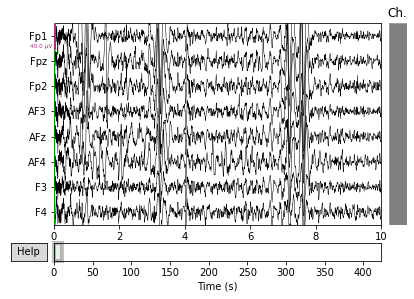

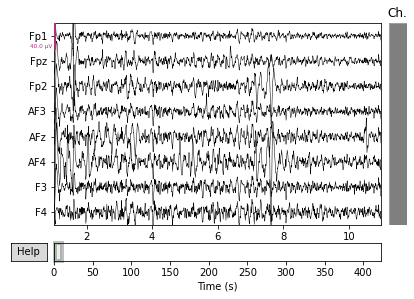

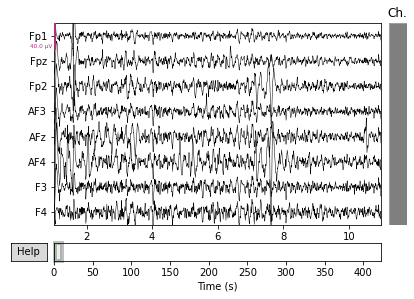

In [19]:
# ica.apply() changes the Raw object in-place, so let's make a copy first for comparison:
orig_raw = raw.copy()  #we apply ica to raw
ica.apply(raw)

regexp = r'(F)|(AF)'
artifact_picks = mne.pick_channels_regexp(raw.ch_names, regexp=regexp)

orig_raw.plot(order=artifact_picks, n_channels=len(artifact_picks))
raw.plot(order=artifact_picks, n_channels=len(artifact_picks), start=1)

# 4. Power spectral analysis (without epoching)

Effective window size : 8.192 (s)


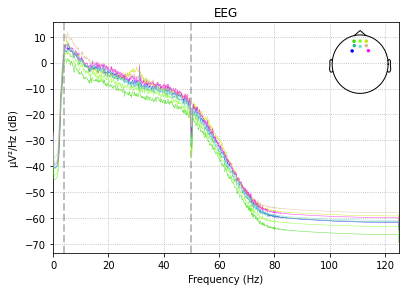

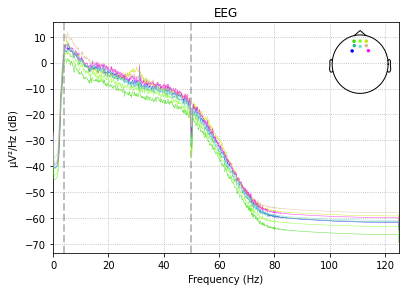

In [20]:
# compute the poweer spectral density (PSD) using 
# the MNE psd_welch function
# (this is simply a wrapper on scipy.signal.welch
#  that adds compatbility for MNE data types)

#this pick is optional but in case you want
#to pick certain channel
picks = mne.pick_types(raw.info, eeg=True, exclude='bads')

#you can also define manually the picks
#picks = [0,1]  here i am choosing the first two channels

raw.plot_psd(n_fft=2048, picks=picks)

## Plotting psd manually

In [21]:
psd, freqs = psd_welch(raw, picks=[0,2])  #welch is a common method of computing power spectral density
psd1, freqs1 = psd_welch(raw, picks=[6,7])

Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


In [22]:
#to get mean
psd = 10 * np.log10(psd)
psd_mean = psd.mean(0)
psd_std = psd.std(0)

psd1 = 10 * np.log10(psd1)
psd1_mean = psd1.mean(0)
psd1_std = psd1.std(0)

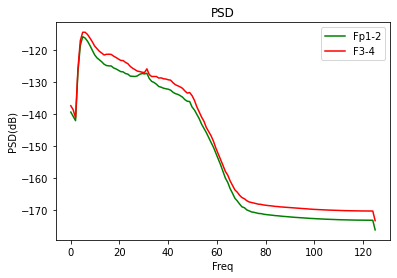

In [23]:
f, ax = plt.subplots()
ax.plot(freqs, psd_mean, color='green', label='Fp1-2')
ax.plot(freqs1, psd1_mean, color='red', label='F3-4')

ax.set(title='PSD', xlabel='Freq', ylabel='PSD(dB)')
plt.legend()
plt.show()

## Plotting using pandas

In [24]:
psd, freqs = psd_welch(raw)  #welch is a common method of computing power spectral density
df_psd = pd.DataFrame(psd, columns=freqs).T

Effective window size : 1.024 (s)


In [25]:
df_psd.tail() #ends at Nyquist Theroem frequency

,0,1,2,3,4,5,6,7
121.093750,2.504672e-18,5.564557e-18,9.547781e-18,7.762609e-18,7.802232e-18,2.248262e-17,8.784488e-18,1.026503e-17
122.070312,2.501550e-18,5.557934e-18,9.536235e-18,7.753391e-18,7.792753e-18,2.245683e-17,8.773690e-18,1.025246e-17
123.046875,2.499323e-18,5.553211e-18,9.528000e-18,7.746817e-18,7.785993e-18,2.243844e-17,8.765989e-18,1.024350e-17
124.023438,2.497989e-18,5.550380e-18,9.523064e-18,7.742876e-18,7.781940e-18,2.242741e-17,8.761373e-18,1.023812e-17
125.000000,1.248772e-18,2.774718e-18,4.760710e-18,3.870782e-18,3.890295e-18,1.121187e-17,4.379918e-18,5.118167e-18


In [26]:
df_psd.columns = raw.ch_names[:8]

In [27]:
df_psd.index.names = ['freq']  #make the plot looks nice with name

In [28]:
df_psd.columns.names = ['chan'] #make the plot looks nice with name

In [29]:
df_psd.head()

chan,Fp1,Fpz,Fp2,AF3,AFz,AF4,F3,F4
freq,,,,,,,,
0.000000,5.517825e-15,1.150929e-14,2.432909e-14,1.850033e-14,1.971547e-14,4.567501e-14,1.523328e-14,2.200528e-14
0.976562,4.089287e-15,8.455883e-15,1.777130e-14,1.357119e-14,1.456303e-14,3.294623e-14,1.141612e-14,1.646075e-14
1.953125,2.813484e-15,6.856945e-15,1.392246e-14,1.451733e-14,9.716970e-15,2.821205e-14,6.511419e-15,8.952911e-15
2.929688,9.425958e-14,2.043126e-13,4.598731e-13,4.271459e-13,3.048801e-13,9.213650e-13,2.363787e-13,2.735161e-13
3.906250,6.219444e-13,1.598654e-12,3.055549e-12,2.874383e-12,1.852048e-12,6.754061e-12,1.663334e-12,2.285127e-12


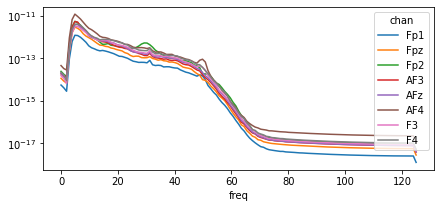

In [30]:
fig, ax = plt.subplots(figsize = (7, 3))
df_psd.plot(logy=True, ax = ax)

## Computing the delta, theta, alpha, beta, and gamma bands

In [31]:
# These are the conventional EEG frequency band names and ranges

freqs = ['delta', 'theta', 'alpha', 'beta', 'lowgamma', 'midgamma']

freq_bands = dict(delta = [0.5,2],
                  theta = [4,8], 
                  alpha1 = [8,10],
                  alpha2 = [10,12],
                  beta = [12,20],
                  lowgamma=[20,30],
                  midgamma=[30,50])

In [32]:
freq_bands.items()

dict_items([('delta', [0.5, 2]), ('theta', [4, 8]), ('alpha1', [8, 10]), ('alpha2', [10, 12]), ('beta', [12, 20]), ('lowgamma', [20, 30]), ('midgamma', [30, 50])])

In [33]:
# Average the power within each of these bands

psd_fb = {}
for band_name, (rlow,rhigh) in freq_bands.items():
    psd_fb[band_name] = df_psd.loc[rlow:rhigh].mean(axis=0)

In [34]:
#psd_fb

In [35]:
# Put in pandas df
df_psd_fb = pd.DataFrame(psd_fb)
df_psd_fb = df_psd_fb.T
df_psd_fb

chan,Fp1,Fpz,Fp2,AF3,AFz,AF4,F3,F4
delta,3.451385e-15,7.656414e-15,1.584688e-14,1.404426e-14,1.214000e-14,3.057914e-14,8.963772e-15,1.270683e-14
theta,1.040965e-12,2.281932e-12,4.152642e-12,4.078742e-12,3.233044e-12,8.431838e-12,2.760471e-12,3.634926e-12
alpha1,4.791460e-13,1.034210e-12,1.543601e-12,1.536220e-12,1.466477e-12,3.084067e-12,1.425728e-12,1.770047e-12
alpha2,2.987358e-13,7.177189e-13,9.521343e-13,1.024551e-12,9.240362e-13,2.024794e-12,9.728843e-13,1.056215e-12
beta,2.032932e-13,3.650493e-13,4.938347e-13,5.586746e-13,6.130885e-13,9.312852e-13,6.250922e-13,7.497676e-13
lowgamma,8.806954e-14,1.547950e-13,3.628449e-13,2.324375e-13,2.566308e-13,4.041037e-13,2.816871e-13,3.622167e-13
midgamma,3.500659e-14,5.939917e-14,1.462197e-13,7.657224e-14,8.986605e-14,1.470549e-13,1.023437e-13,1.280915e-13


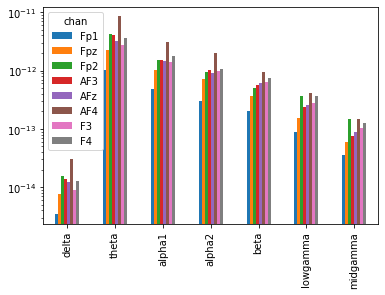

In [36]:
df_psd_fb.plot(kind='bar', logy=True) #logy to scale the delta

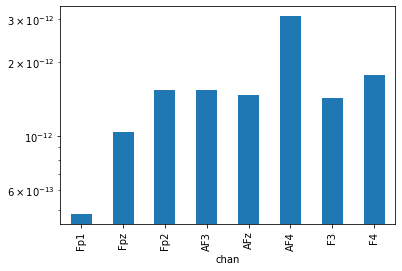

In [37]:
#plotting certain frequency
chans = ['Fp1', 'Fpz', 'Fp2', 'AF3', 'AFz', 'AF4', 'F3', 'F4']
df_psd_fb[chans].loc['alpha1'].plot(kind='bar', logy=True)

# 4. Epoching

In [38]:
#this one requires expertise to specify the right tmin, tmax
event_id = {'Amusement': 1, 'Anger' : 2}
epochs = helper.getEpochs(raw, event_id, tmin=1, tmax=2.5)

100 events found
Event IDs: [1 2]
sample drop %:  2.0000000000000018


To avoid biasing our signals, we’ll use equalize_event_counts() first to randomly sample epochs from each condition to match the number of epochs present in the condition with the fewest good epochs.

In [39]:
conds_we_care_about = ['Amusement', 'Anger']
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
amuse_epochs = epochs['Amusement']
anger_epochs = epochs['Anger']
#del raw, epochs  # free up memory - here I am not gonna do that

print(amuse_epochs)
print(anger_epochs)

<Epochs  |   46 events (all good), 1 - 2.5 sec, baseline off, ~1.1 MB, data loaded,
 'Amusement': 46>
<Epochs  |   46 events (all good), 1 - 2.5 sec, baseline off, ~1.1 MB, data loaded,
 'Anger': 46>


46 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
46 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
46 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


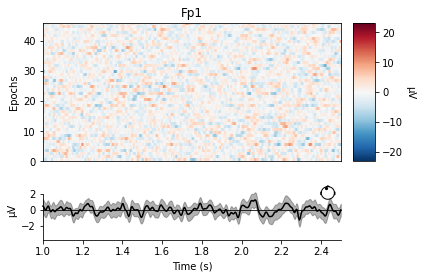

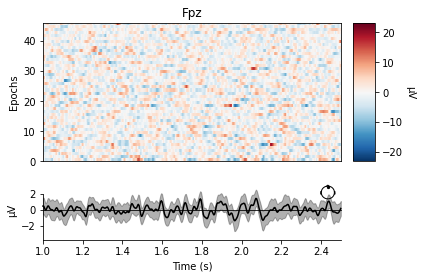

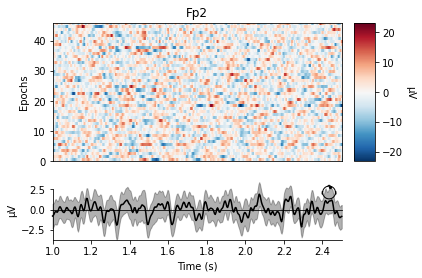

[<Figure size 432x288 with 4 Axes>,
 <Figure size 432x288 with 4 Axes>,
 <Figure size 432x288 with 4 Axes>]

In [40]:
epochs['Anger'].plot_image(picks=[0,1,2])

## Averaging into band

Effective window size : 4.112 (s)
Effective window size : 4.112 (s)


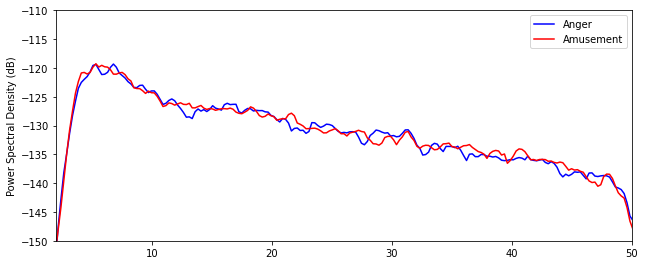

In [41]:
fig = plt.figure(figsize=(10, 4))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

psd1, freq1 = psd_welch(epochs['Anger'], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs['Amusement'], n_fft=1028, n_per_seg=256 * 3)

logpsd1 = 10 * np.log10(psd1)
logpsd2 = 10 * np.log10(psd2)

log_psd1_mean = logpsd1.mean(0)
log_psd1_std = logpsd1.mean(0)

log_psd2_mean = logpsd2.mean(0)
log_psd2_std = logpsd2.mean(0)

axes.plot(freq1, log_psd1_mean[[0, 7], :].mean(0), color='b', label='Anger')
axes.plot(freq2, log_psd2_mean[[0, 7], :].mean(0), color='r', label='Amusement')

axes.set_title('')
axes.set_ylabel('Power Spectral Density (dB)')
axes.set_xlim((2, 50))
axes.set_ylim((-150, -110))
axes.legend()

In [42]:
#Anger dataFrame
df_psd1 = pd.DataFrame(psd1.mean(0), columns=freq1).T
df_psd1.columns = raw.ch_names[:8]
df_psd1.index.names = ['freq']  #make the plot looks nice with name
df_psd1.columns.names = ['chan'] #make the plot looks nice with name

psd_fb1 = {}
for band_name, (rlow,rhigh) in freq_bands.items():
    psd_fb1[band_name] = df_psd1.loc[rlow:rhigh].mean(axis=0)

# Put in pandas df
df_psd_fb1 = pd.DataFrame(psd_fb1).T
df_psd_fb1


chan,Fp1,Fpz,Fp2,AF3,AFz,AF4,F3,F4
delta,4.905022e-16,1.091240e-15,2.066384e-15,2.544803e-15,1.494576e-15,4.090076e-15,1.761693e-15,1.851924e-15
theta,7.893680e-13,1.428202e-12,3.207301e-12,2.685030e-12,2.442304e-12,6.761238e-12,2.362686e-12,3.131147e-12
alpha1,4.581305e-13,7.370977e-13,1.344069e-12,1.424602e-12,1.405499e-12,2.288352e-12,1.596501e-12,1.661462e-12
alpha2,2.626561e-13,5.173415e-13,6.505318e-13,8.279060e-13,8.287860e-13,1.400984e-12,8.963703e-13,9.720019e-13
beta,1.741968e-13,3.090593e-13,4.311571e-13,4.773887e-13,5.920139e-13,7.645513e-13,5.984972e-13,7.392195e-13
lowgamma,7.596148e-14,1.256312e-13,3.473571e-13,1.887345e-13,2.286977e-13,3.257942e-13,2.627017e-13,3.018803e-13
midgamma,2.875161e-14,4.642322e-14,1.329373e-13,6.513184e-14,7.439355e-14,1.200139e-13,8.381631e-14,1.046864e-13


In [43]:
#Amusement dataFrame
df_psd2 = pd.DataFrame(psd2.mean(0), columns=freq2).T
df_psd2.columns = raw.ch_names[:8]
df_psd2.index.names = ['freq']  #make the plot looks nice with name
df_psd2.columns.names = ['chan'] #make the plot looks nice with name
df_psd2

psd_fb2 = {}
for band_name, (rlow,rhigh) in freq_bands.items():
    psd_fb2[band_name] = df_psd2.loc[rlow:rhigh].mean(axis=0)

# Put in pandas df
df_psd_fb2 = pd.DataFrame(psd_fb2)
df_psd_fb2 = df_psd_fb2.T

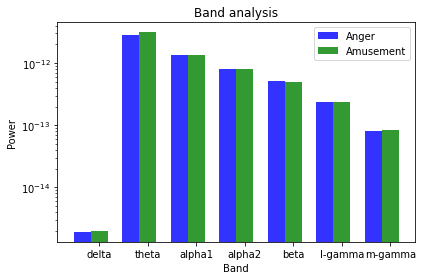

In [44]:
fig, ax = plt.subplots()
index = np.arange(len(df_psd_fb1.mean(axis=1)))
bar_width = 0.35
opacity = 0.8

anger = plt.bar(index, df_psd_fb1.mean(axis=1), bar_width, alpha=opacity,
                color='b', label='Anger', log=True)

amusement = plt.bar(index + bar_width, df_psd_fb2.mean(axis=1), bar_width, alpha=opacity,
                color='g', label='Amusement', log=True)

plt.xlabel('Band')
plt.ylabel('Power')
plt.title('Band analysis')
plt.xticks(index + bar_width, ('delta', 'theta', 'alpha1', 
                               'alpha2', 'beta', 'l-gamma', 'm-gamma'))

plt.legend()
plt.tight_layout()

plt.show()


# 5.1 Modeling 1: Power Spectral Features >  Classification

In [45]:
import spectralDecoding as spec #custom

event_id = {'Amusement': 1, 'Anger': 2} 
spec.decode(raw, event_id, tmin=1, tmax=2.5)  #comment this out when you want to try

100 events found
Event IDs: [1 2]
sample drop %:  2.0000000000000018
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.4782608695652174
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.391304347826087
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.43478260869565216
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.43478260869565216
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.34782608695652173
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.43478260869565216
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.4782608695652174
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.43478260869565216
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.391304347826087
E

# 5.2 Modeling 2: Filter-bank > Common Spatial Pattern > Classification

In [ ]:
import filterbankcspDecoding as fcsp #custom

event_id = {'Amusement': 1, 'Anger': 2}
fcsp.decode(raw, event_id, tmin=1, tmax=2.5, band_width=4, band_overlap=2, low_freq=4, n_filters=23)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6 - 10 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 6.00, 10.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 12.00 Hz: -6.02, -6.02 dB



/home/chaklam/bci_project/bci_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/chaklam/bci_project/bci_env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 14 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 10.00, 14.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 12 - 16 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 12.00, 16.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 14 - 18 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 14.00, 18.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up b

# 5.3 Modeling 3: LSTM

In [ ]:
import lstmDecoding as lstm #custom

#will not work well if we have only a few samples
event_id = {'Amusement': 1, 'Anger': 2}
lstm.decode(raw, event_id, tmin=1, tmax=2.5)

# 5.4 Modeling 4: Temporal Convolutional network